In [2]:
import os
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
import zipfile
import cv2 as cv
import torch
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import copy
from PIL import Image
import glob
import random
import torch
from torchvision import transforms
import re

In [4]:
def sample_tile_images(N_cancer, N_noncancer, path):
    cancer_imgs = glob.glob(os.path.join(path, '*_cancer.png')) # select all file paths of images containing cancer
    noncancer_imgs = glob.glob(os.path.join(path, '*_noncancer.png')) # same for images not containing any cancer
    tiles = random.sample(cancer_imgs, N_cancer) + random.sample(noncancer_imgs, N_noncancer) # sample N_cancer and N_noncancer file paths from the two lists above
    labels = np.concatenate((np.ones(N_cancer), np.zeros(N_noncancer))) # label as 1 for cancer and 0 for non-cancer
    indices = list(range(N_cancer + N_noncancer)) 
    random.shuffle(indices) # random list of indices to shuffle the list containing cancer and non-cancer file paths
    return [tiles[i] for i in indices], labels[indices]

non-cancer


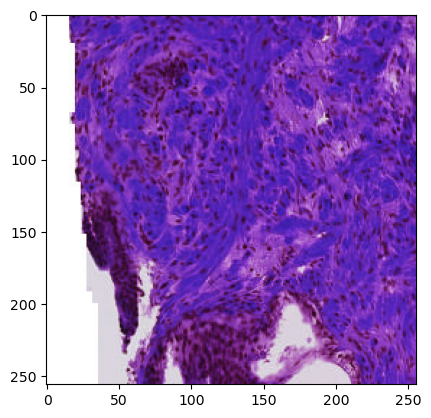

In [5]:
path = "data/tiled_images/output/" # path to the folder containing the imgs

cancer_imgs = glob.glob(os.path.join(path, '*_cancer.png')) # select all file paths of images containing cancer
noncancer_imgs = glob.glob(os.path.join(path, '*_noncancer.png')) # same for images not containing any cancer
# len(cancer_imgs)
# len(noncancer_imgs)

N_cancer = 100 # number of imgs with cancer
N_noncancer = 100 # number of imgs without cancer

# Display some random images to observe the features of cancer vs non-cancer cells
tiles, labels = sample_tile_images(N_cancer, N_noncancer, path) # get list of train images
label_dict = {1: 'cancer', 0: 'non-cancer'} # dictionary of labels
# j = random.randint(0, len(labels)) # pick a random image
j = 0 # pick a random image
im_frame = Image.open(tiles[j])
np_frame = np.array(im_frame)
plt.imshow(np_frame)
print(label_dict[labels[j]])

In [8]:
def train_model(net, dataloader, criterion, optimizer, epochs=5):
    i = 0
    run_loss = 0
    # print start
    print('Start of training')
    for epoch in range(epochs):
        print('Epoch:', epoch)
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            run_loss += loss.item()
        # print statistics
        print('Loss:', run_loss, '\n')
        run_loss = 0.0
        
    return net

pxsize = 227 # size of the images to be used by the network, can be center-cropped below 256

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(pxsize),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
# Split and prepare data for training
train_fraction = 0.7 # fraction of train samples
pxsize = 227 # size of the images to be used by the network, can be center-cropped below 256
random.seed(123)

tiles, labels = sample_tile_images(N_cancer, N_noncancer, path) # get list of train images
data = preprocess(Image.open(tiles[0]).convert('RGB')).reshape(1,3,pxsize,pxsize) # convert to RGB to drop alpha (transparency) channel of png 

for tile in tiles[1:]:
    data = torch.cat((preprocess(Image.open(tile).convert('RGB')).reshape(1,3,pxsize,pxsize), data), axis=0)

X_train, X_validation = torch.split(data, int(train_fraction*len(data)))
y_train, y_validation = torch.split(torch.Tensor(labels).type(torch.LongTensor), int(train_fraction*len(labels)))

In [15]:
import torch

print("Torch version:",torch.__version__)

print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.1.1+cpu
Is CUDA enabled? False


In [13]:
torch.manual_seed(123)

# Define hyperparamerts of the network and train it
batch_size = 32
train_dataset = TensorDataset(X_train, y_train) 
dataloader = DataLoader(train_dataset, batch_size = batch_size)
res50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    
res50.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2),
               nn.Softmax())

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(res50.fc.parameters(), lr=0.0001)
res50.to('cuda')
epochs = 3

run_loss = 0
# print start
print('Start of training')
for epoch in range(epochs):
    print('Epoch:', epoch)
    for inputs, labels in dataloader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = res50.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
    # print statistics
    print('Loss:', run_loss, '\n')
    run_loss = 0.0

Start of training
Epoch: 0


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
from sklearn.metrics import confusion_matrix

pred_labels = torch.argmax(net(X_validation), axis=1)
print("Predicted labels")
print(pred_labels)
print("True labels")
print(y_validation)

C = confusion_matrix(pred_labels, y_validation)
print("Confusion Matrix")
print(C)
print("Accuracy: ", (sum(pred_labels==y_validation)/len(pred_labels)).item())